## Setup

In [1]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim

In [2]:
jax.__version__, _galsim.__version__

('0.4.14', '2.4.11')

In [3]:
# Working in float64
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put

In [4]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
jax.devices()

[gpu(id=0)]

## Fit single galaxy from galsim (no shear)

### global params

In [114]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e3
NOISE = 1

# galaxy
HLR = 0.9
TRUE_FLUX = 1e5

### functions

In [115]:
# get true image
def _draw_gal():
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=HLR)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    im = gal_conv.array
    im += np.random.randn(*im.shape) * np.sqrt(BACKGROUND) * NOISE
    return im

In [116]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_gal(f):
    gal = galsim.Gaussian(flux=f, half_light_radius=HLR)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    return image.array

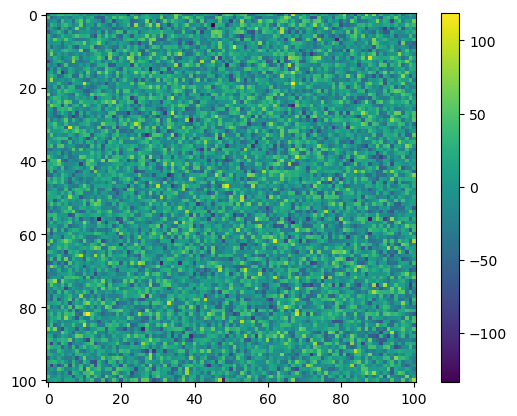

In [123]:
# check error is very small on true thingies
f = jnp.array([TRUE_FLUX])
arr = _draw_gal() - draw_gal(f)
plt.imshow(arr)
plt.colorbar()

### Fit!

In [130]:
def prob_model(y=None):
    f = numpyro.sample('f', dist.Normal(1e5, 3e4))
    im = draw_gal(jnp.array([f]))
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=y)

In [146]:
TRUE_IMAGE = _draw_gal()
nuts_kernel = NUTS(prob_model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=3000)
rng_key = random.PRNGKey(5)
mcmc.run(rng_key, y=TRUE_IMAGE)

sample: 100%|██████████| 4000/4000 [00:10<00:00, 399.79it/s, 3 steps of size 8.57e-01. acc. prob=0.94]


In [147]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         f  99947.99    537.97  99959.24  99012.65 100797.75   1239.35      1.00

Number of divergences: 0


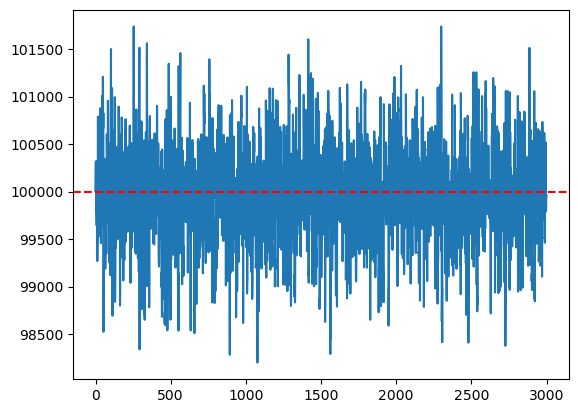

In [148]:
plt.plot(mcmc.get_samples()['f'])
plt.axhline(TRUE_FLUX,color='r', ls='--') 

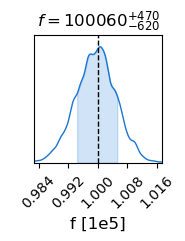

In [149]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['f']},
    name='Posterior'
)
fig = c.plotter.plot(truth={'f':1e5})

In [150]:
dist.Normal(draw_gal(TRUE_FLUX), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum() # max 

Array(-49758.75, dtype=float32)

In [151]:
mean_params = {k:jnp.array([jnp.mean(v)]) for k,v in mcmc.get_samples().items()}
dist.Normal(draw_gal(**mean_params), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum()

Array(-49758.742, dtype=float32)

## Fit single gaussian with flux + hlr

In [194]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e4
NOISE = 1

# galaxy
TRUE_HLR = 1.0
LOG_TRUE_FLUX = 5
TRUE_FLUX = 10**LOG_TRUE_FLUX

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}

In [195]:
# get true image
def _draw_gal(noise=NOISE):
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    im = gal_conv.array
    im += np.random.randn(*im.shape) * np.sqrt(BACKGROUND) * noise
    return im

In [196]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_gal(lf, hlr):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE)
    return image.array

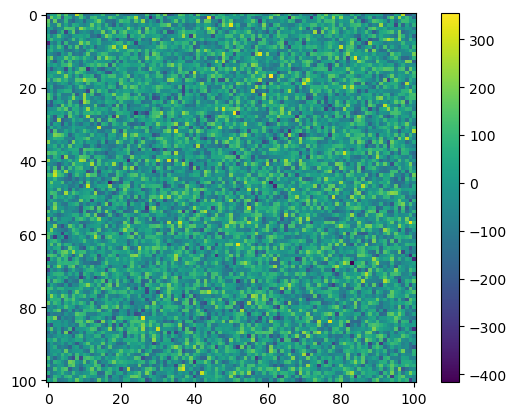

In [197]:
# check error is very small on true thingies
arr = _draw_gal() - draw_gal(**TRUE_PARAMS_ARR)
plt.imshow(arr)
plt.colorbar()

In [203]:
def prob_model(y=None):
    params = {
        'lf': numpyro.sample('lf', dist.Uniform(4.5,5.5)),
        'hlr': numpyro.sample('hlr', dist.Uniform(0.7, 1.5)),
    }
    params = {k:jnp.array([v]) for k,v in params.items()}
    im = draw_gal(**params)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=y)

In [204]:
TRUE_IMAGE = _draw_gal()
nuts_kernel = NUTS(prob_model, max_tree_depth=10) 
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=4000)
rng_key = random.PRNGKey(2)
mcmc.run(rng_key, y=TRUE_IMAGE)

sample: 100%|██████████| 6000/6000 [00:23<00:00, 260.72it/s, 1 steps of size 5.08e-01. acc. prob=0.94] 


In [205]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       hlr      1.00      0.03      1.00      0.96      1.05   1513.65      1.00
        lf      4.99      0.01      4.99      4.97      5.01   1534.03      1.00

Number of divergences: 0


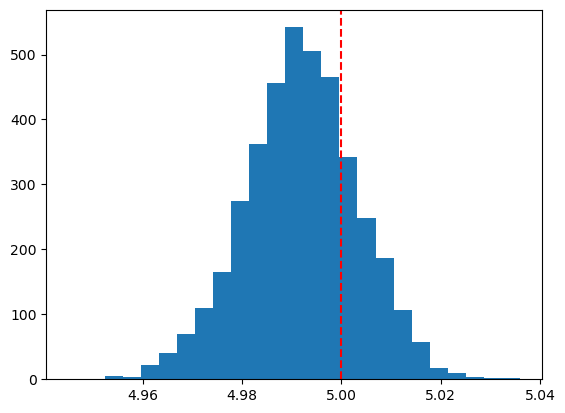

In [206]:
plt.hist(mcmc.get_samples()['lf'], bins=25)
plt.axvline(LOG_TRUE_FLUX, ls='--', color='r')

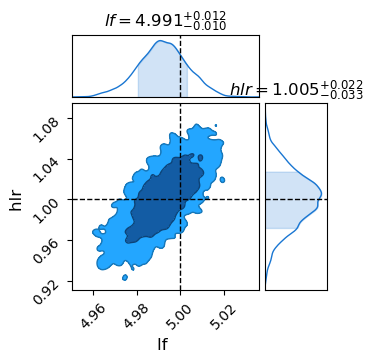

In [207]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['lf', 'hlr']},
    name='Posterior'
)
fig = c.plotter.plot(truth=TRUE_PARAMS)

In [208]:
dist.Normal(draw_gal(**TRUE_PARAMS_ARR), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum() # max 

Array(-61502.64, dtype=float32)

In [209]:
mean_params = {k:jnp.array([jnp.mean(v)]) for k,v in mcmc.get_samples().items()}
dist.Normal(draw_gal(**mean_params), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum()

Array(-61502.156, dtype=float32)

## Fit single gaussian galaxy with shear (and other parameters)

In [228]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 101
BACKGROUND = 1e4

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 5
TRUE_FLUX = 10**LOG_TRUE_FLUX
TRUE_X = 0.
TRUE_Y = 0.
 
#shear
G1 = 0.02
G2 = 0.0

#params
TRUE_PARAMS = {'lf': LOG_TRUE_FLUX, 'hlr': TRUE_HLR, 'x': TRUE_X, 'y': TRUE_Y, 'g1': G1, 'g2': G2}
TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}

In [229]:
im = _draw_gal(0)
print('snr:', np.sqrt(np.sum(im * im / (BACKGROUND + im))))

snr: 56.890995


In [230]:
# get true image
def _draw_gal(noise=1):
    gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
    gal = gal.shear(g1=G1, g2=G2)
    pos = _galsim.PositionD(x=TRUE_X, y=TRUE_Y)
    psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = _galsim.Convolve([gal, psf])
    gal_conv = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE, 
                                  offset=pos,
                                 )
    im = gal_conv.array
    im += np.random.randn(*im.shape) * np.sqrt(BACKGROUND) * noise
    return im

In [231]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_gal(lf, hlr, x, y, g1, g2):
    gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    pos = galsim.PositionD(x=x, y=y)
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 offset=pos, 
                                 )
    return image.array

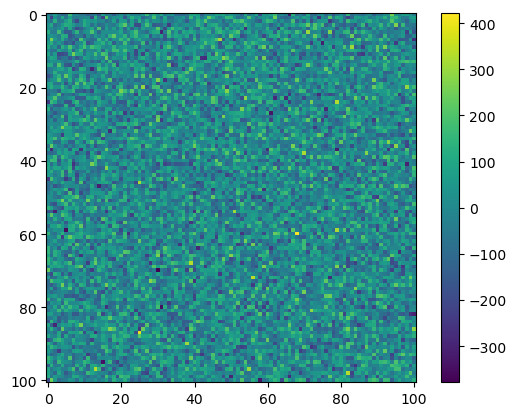

In [232]:
# check error is very small on true thingies
arr = _draw_gal() - draw_gal(**TRUE_PARAMS_ARR)
plt.imshow(arr)
plt.colorbar()

In [293]:
def prob_model(y=None):
    params = {
        'lf': numpyro.sample('lf', dist.Uniform(4.5,5.5)),
        'hlr': numpyro.sample('hlr', dist.Uniform(0.7, 1.5)),
        'x': numpyro.sample('x', dist.Uniform(-0.5, 0.5)),
        'y': numpyro.sample('y', dist.Uniform(-0.5, 0.5)),
        'g1':numpyro.sample('g1', dist.Uniform(-0.1, 0.1)),
        'g2':numpyro.sample('g2', dist.Uniform(-0.1, 0.1)),
    }
    params = {k:jnp.array([v]) for k,v in params.items()}
    im = draw_gal(**params)
    numpyro.sample('obs', dist.Normal(im, jnp.sqrt(BACKGROUND)), obs=y)

In [294]:
TRUE_IMAGE = _draw_gal()
nuts_kernel = NUTS(prob_model, max_tree_depth=10) 
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=6000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, y=TRUE_IMAGE)

sample: 100%|██████████| 8000/8000 [01:04<00:00, 123.50it/s, 15 steps of size 4.92e-01. acc. prob=0.92]


In [295]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        g1      0.02      0.03      0.02     -0.02      0.07   7758.96      1.00
        g2     -0.00      0.03     -0.00     -0.05      0.04   5879.54      1.00
       hlr      0.89      0.03      0.89      0.84      0.93   4855.74      1.00
        lf      5.00      0.01      5.00      4.98      5.01   5003.15      1.00
         x     -0.14      0.12     -0.14     -0.34      0.06   7180.85      1.00
         y     -0.15      0.11     -0.15     -0.34      0.04   6178.15      1.00

Number of divergences: 0


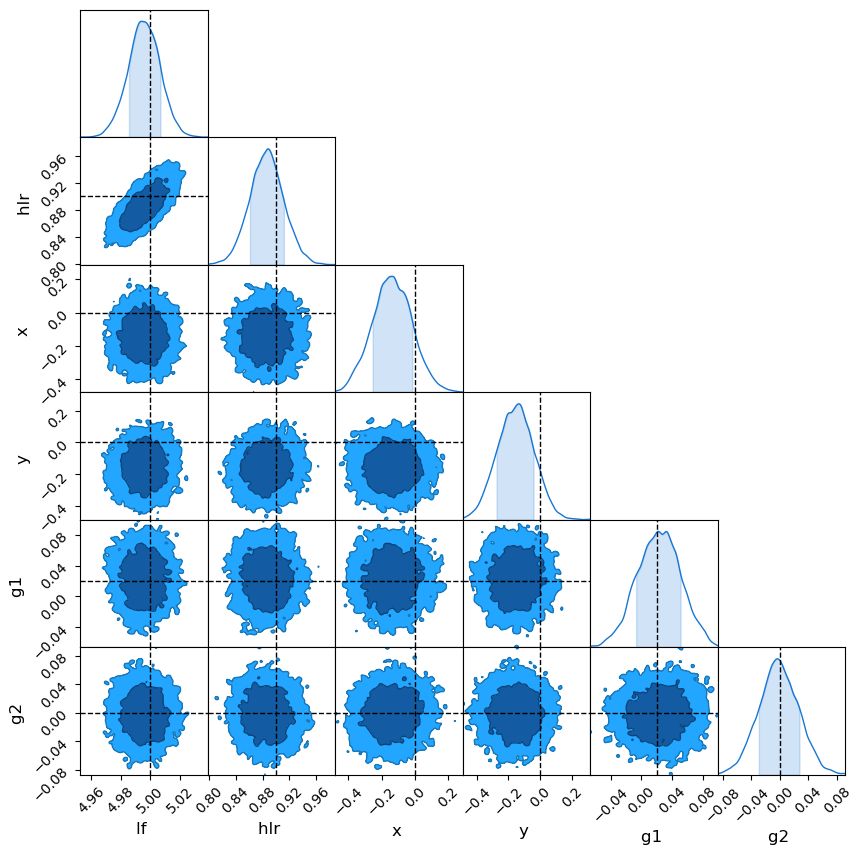

In [296]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['lf', 'hlr', 'x', 'y', 'g1', 'g2']},
    name='Posterior'
)
fig = c.plotter.plot(truth=TRUE_PARAMS)

In [297]:
dist.Normal(draw_gal(**TRUE_PARAMS_ARR), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum()

Array(-61471.887, dtype=float32)

In [298]:
mean_params = {k:jnp.array([jnp.mean(v)]) for k,v in mcmc.get_samples().items()}
dist.Normal(draw_gal(**mean_params), jnp.sqrt(BACKGROUND)).log_prob(TRUE_IMAGE).sum()

Array(-61470.22, dtype=float32)